# Two Decades of NBA 2K Player Ratings
**Data Retrieved From:** https://maddenratings.weebly.com/  
**Author:** Logan Donaldson  
**Date Published:** June 3, 2021  

As professional sports, and in particular basketball, increasingly embrace analytics, the metrics used to assess players' performance become more numerous and complex. It is no longer sufficient to merely consider average points per game when assessing offensive ability or blocked shots when determining defensive prowess. More sophisticated metrics such as true shooting percentage, real adjusted player efficiency rating, and Per 87.5 have been developed in hopes of better quantifying a player's value. Yet despite their mathematical sophistication, no collection of metrics will provide an objectively correct assessment. Instead of considering numerous complex statistics one could take a reductionist approach by creating a simple metric that sacrifices correctness for ease of use. What if instead of developing increasingly advanced metrics we took the opposite approach? What if we sought to distill a professional basketball player's skill level to a single number? What would such a number look like? In fact such a metric already exists.

The NBA 2K video game franchise has released a game for each of the last 21 NBA basketball seasons and in each entry every active NBA basketball player is assigned a rating on scale from 1-99, where higher scores correspond to better players. In practice most players receive a score of 60 or above. In this way, each player's skill is summarized into a single number allowing for easy, interesting comparisons.

In this project we collect and analyze this player rating data. In doing so we reduce the last 21 years of NBA history into simplistic quantitative terms.

In [16]:
import pandas as pd
import bs4
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
from bs4 import BeautifulSoup as soup

plt.style.use('seaborn-colorblind')

After some import statements we scrape the data using BeautifulSoup. Our data source only includes players with a rating >= 83. This means that role players, rotational players and below average starters were not included in this analysis. For each of the NBA 2k games released between 2001 and 2021 we scrape each player's name, rating, team, and position. The data is spread out between 21 different webpages, one for each game/year, so we visit each individually and extract the html code.

In [17]:
page_soup = []
year = 6

#Visit each webpage sequentially and extract html
for year in range (1, 22):
    if (year == 4):
        my_url = 'https://maddenratings.weebly.com/espn-nba-basketball.html'
    elif(year == 5):
        my_url = 'https://maddenratings.weebly.com/espn-nba-2k5.html'
    else:
        my_url = 'https://maddenratings.weebly.com/nba-2k' + str(year) + '.html'
    
    uClient = urlopen(my_url)
    page_html = uClient.read()
    uClient.close()
    page_soup.append(soup(page_html, "html.parser"))

With the html code extracted we now parse the html code and organize the data into a data frame.

In [18]:
position = []
rating = []
name = []
team = []
year = []

#Loop through extracted html for each webpage
for i in range(2001,2022):
    
    #Extract relevant html using the appropriate tag
    containers = page_soup[i-2001].findAll("div", {"style":"display:block;font-size:90%"})
    
    #Loop throup the extracted html strings
    for j in range(0, len(containers)):
        
        #If '|' is not in the string then it corresponds to a team, not a player, so we ignore it
        if('|' not in str(containers[j])):
            continue
            
        #Split string up to aid in data extraction    
        data = (str(containers[j]).split(">"))
        
        #If this string contains '-' then this is a legacy player so we ignore it 
        if ('-' in data[3][:-5]):
            continue
        
        #A Special case for Centers since their position abbreviation is a single letter
        #Extract position and rating from approriate strings
        if(data[1][0] == 'C'):
            position.append(data[1][0])
            rating.append(data[1][4:6])
        else:
            position.append(data[1][0:2])
            rating.append(data[1][5:7]) 
        
        #Extract player name and team name from approriate strings, record year based on for loop variable
        name.append(data[2][:-4])
        team.append(data[3][:-5])
        year.append(i)

#Convert arrays to Series to allow for each data frame creation
sPosition = pd.Series(position, name = "Position")
sRating = pd.Series(rating, name = "Rating")
sName = pd.Series(name, name = "Name")
sTeam = pd.Series(team, name = "Team")
sYear = pd.Series(year, name = "Year")

df = pd.concat([sPosition, sName, sRating, sTeam, sYear], axis = 1)
pd.set_option("display.max_rows", None, "display.max_columns", None)

#Remove rows corresponding to WNBA Players
df.drop(df.index[862:877],0,inplace=True)
df.drop(df.index[782:800],0,inplace=True)
df.reset_index(drop=True, inplace=True)

#Fix anomalous data
df.at[292,'Rating']='97'
df.at[749,'Rating']='87'
df.at[17,'Rating']='87'
df.at[52,'Rating']='84'
df.at[85,'Rating']='94'

df.at[581,'Team']='Grizzlies'
df.at[473,'Team']='Bulls'

df.at[346,'Name']="Shaquille O'Neal"

#Convert Rating Column from String to int
df['Rating'] = pd.to_numeric(df['Rating'])

print("Shape of Data Frame: " + str(df.shape))
df.head()

Shape of Data Frame: (844, 5)


,Position,Name,Rating,Team,Year
0,PF,Kevin Garnett,99,Timberwolves,2001
1,SG,Kobe Bryant,98,Lakers,2001
2,PF,Tim Duncan,98,Spurs,2001
3,C,Shaquille O'Neal,98,Lakers,2001
4,PG,Gary Payton,97,SuperSonics,2001


It is important to keep in mind that our analysis is limited to only the top players, not the entire NBA. We will refer to players in this data set as 'Star Players.' The first step in our analysis is to recognize that the NBA 2K rating philosophy has undergone changes over the past couple decades. This is evident from the plot below which shows that the number of highly rated players varies drastically between games.

Mean # of players with rating >= 83: 40.19
Stadard Deviation: 12.42


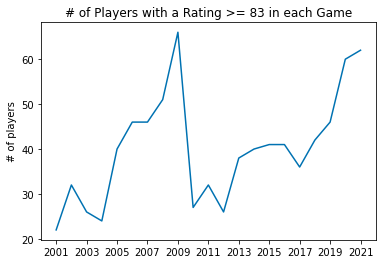

In [19]:
yearCount = df.Year.value_counts(sort=False)

yearCount.plot(title = "# of Players with a Rating >= 83 in each Game", ylabel = "# of players", 
               xticks = list(range(2001,2022,2)))
print("Mean # of players with rating >= 83: " + str(round(yearCount.mean(),2)))
print("Stadard Deviation: " + str(round(yearCount.std(),2)))

The talent in the NBA does not vary wildly from year to year. Thus if the rating philosophy remained consistent one would expect much less variation in the number of highly rated players between each game. This makes our analysis slightly problematic. For example, players who would have received a rating of 83 and thus been included in the data in 2008, may not have been included in the year 2001. Nonetheless the players were subjected to the changing standards equally.

Another defining characteristic of the NBA 2k rating system is the distribution of the scores. In general less fewer players are assigned to the higher scores. This relationship between rating and the number of player's receiving the rating is illustrated in the histogram below.

Mean Rating: 88.4
Stadard Deviation: 4.38


<AxesSubplot:title={'center':'Rating Distribution'}, ylabel='Frequency'>

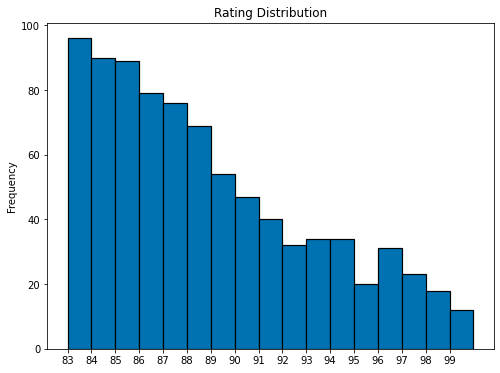

In [20]:
print("Mean Rating: " + str(round(df.Rating.mean(),2)))
print("Stadard Deviation: " + str(round(df.Rating.std(),2)))
df.Rating.plot(kind = "hist", bins = range(83,101), xticks = range(83,100), title = "Rating Distribution", xlabel = "Rating",edgecolor='black', linewidth=1.2, figsize = (8,6))

Next we compare the number of top players who played each position.

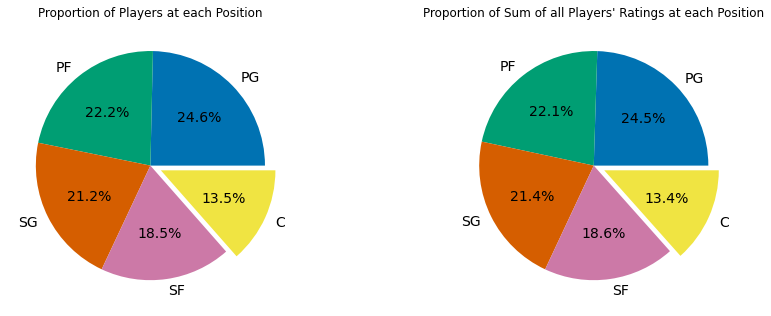

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(14, 4.5))

#Plot number of players at each position
positionPlayerCount = df.Position.value_counts()
positionPlayerCount.plot(kind = "pie", ax = axs[0], title = "Proportion of Players at each Position", 
                         ylabel = "", autopct='%1.1f%%', explode = (0,0,0,0,0.1), textprops={'fontsize': 14})

#Plot the sum of the ratings of the players at each position
positionRatingCount = df.groupby('Position')['Rating'].sum().sort_values(ascending = False)
positionRatingCount.plot(kind = "pie", ax=axs[1], title = "Proportion of Sum of all Players' Ratings at each Position", 
                         ylabel = "", autopct='%1.1f%%',explode = (0,0,0,0,0.1), textprops={'fontsize': 14})

#Make layout visually appealing
plt.tight_layout()

The left chart shows the proportion of players at each position in our data set. To make the chart on the right, we sum all the ratings in the data set and then plot the proportion of the sum that can be attributed to players in each position. We see that centers are markedly underrepresented while point guards are slightly overrepresented. We cannot definitively assert that this discrepancy is due to a lack of skilled players at the center position without also knowing the distribution of the positions throughout the entire NBA. It could be the case that there are simply less centers on rosters.

We now look at the similar pair of bar charts. The chart on the left shows the number of 'star players' each team has had over the past 21 seasons. The chart on the right shows the sum of these star players' ratings, a value we named 'Star Power.'
  
Note that the Supersonics (2001-2007), Bobcats (2004-2013), Pelicans (2013-2021), and Thunder (2008-2021) did not play games in all the 21 seasons we are analyzing. Additionally, the name "Hornets" has been applied to a few different franchises over the time period. For the sake of this analysis, we assign players to teams using the team’s name printed on their jersey in the game.

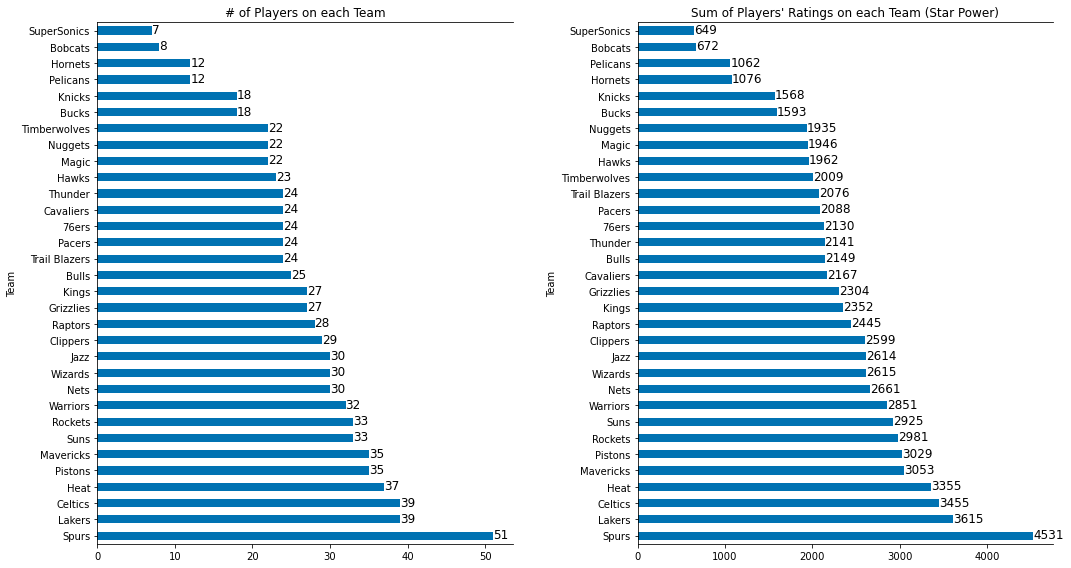

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 8))

#Plot number of players on each team
teamPlayerCount = df.Team.value_counts()
chartPlayerCount = teamPlayerCount.plot(kind = "barh", ax = axs[0], title = "# of Players on each Team", 
                         ylabel = "# of players", xlabel = "Team")

#Add percentages to top of bars, code adapted from https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
for i in chartPlayerCount.patches:
    chartPlayerCount.text(i.get_width(), i.get_y() + .08, i.get_width(), fontsize=12)

#Plot the sum of the ratings of the players on each team
teamRatingCount = df.groupby('Team')['Rating'].sum().sort_values(ascending = False)
chartRatingCount = teamRatingCount.plot(kind = "barh", ax=axs[1], title = "Sum of Players' Ratings on each Team (Star Power)", 
                         ylabel = "Rating Sum", xlabel = "Team")

#Add percentages to top of bars, code adapted from https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html

for i in chartRatingCount.patches:
    chartRatingCount.text(i.get_width(), i.get_y() + .08, i.get_width(), fontsize=12)

#Make layout visually appealing
plt.tight_layout()
plt.subplots_adjust(wspace = 0.3)
axs[0].spines['right'].set_visible(False)
axs[1].spines['right'].set_visible(False)

The Spurs have had the most star players by a fair margin. Of the team names that were in use for all 21 seasons under consideration the Hornets had the least. The discrepancy between these two is 39-star players.  Another interesting point to note is that the Thunder, despite only being created in 2008 had more star players than 7 long established franchises. Considering the entire graph, we see that the despite the league's best efforts to create parity there remains large discrepancies in each team's Star Power. In any given season one would except large differences in teams' Star Power, but over two decades these discrepancies should shrink if the league's efforts are effective. We can conclude that compensating the worst teams with the highest draft picks is insufficient as stars continue to be unevenly distributed amongst the franchises. The NBA, to their credit, have recognized the issue and implemented the super-max contract in 2017 which is designed to entice super stars to remain in small markets. The effectiveness of this measure remains to be seen. If the NBA 2K franchise had older releases it would be interesting to compare Star Power over the entirety of the NBA's history as teams like the Bulls would certainly see a boost.

The team with the most Star Power to not win an NBA championship over this period are the Rockets. The team with the least Star Power to win an NBA championship over this period are the Cavaliers.

Next, we consider the proportion of the league's Star Power which was on each championship team. The lower this proportion the more impressive the championship as the theoretically relied on lower caliber players working well together rather than a few super stars dominating the game.

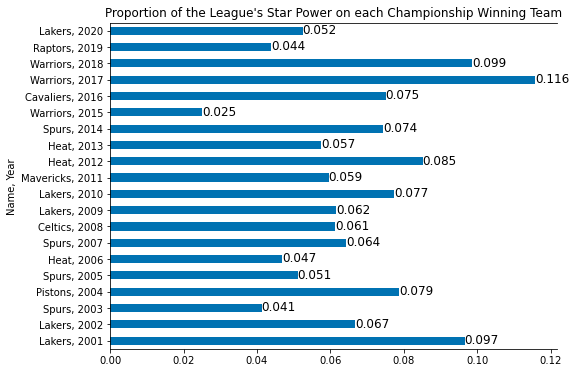

In [23]:
starPowerProportion = []
champName = ['Lakers','Lakers','Spurs','Pistons','Spurs','Heat','Spurs','Celtics','Lakers',
             'Lakers','Mavericks','Heat','Heat','Spurs','Warriors','Cavaliers','Warriors','Warriors','Raptors','Lakers']
for i in range(2001,2021):
    totalStarPower = df.loc[(df['Year'] == i)].Rating.sum()
    champStarPower = df.loc[((df['Team'] == champName[i-2001]) & (df['Year'] == i))].Rating.sum()
    starPowerProportion.append(champStarPower / totalStarPower)
    champName[i-2001] = champName[i-2001] + ", " + str(i) 

schampName = pd.Series(champName, name = "champName")
sStarPowerProportion = pd.Series(starPowerProportion, name = "starPowerProportion")

dfChamp = pd.concat([schampName, sStarPowerProportion], axis = 1)
dfChamp.set_index("champName", inplace = True)
chartStarPowerProportion = dfChamp.starPowerProportion.plot(kind="barh", title = "Proportion of the League's Star Power on each Championship Winning Team", 
                                 xlabel = "Name, Year", ylabel="Star Power", figsize = (8,6))

for i in chartStarPowerProportion.patches:
    chartStarPowerProportion.text(i.get_width(), i.get_y() + .08, round(i.get_width(),3), fontsize=12)

chartStarPowerProportion.spines['right'].set_visible(False)

The chart indicates that the 2015 Warriors were the championship team with the least Star Power relative to their peers. However, looking at an alternative data source we found that the 2015 Warriors had three players (Klay Thompson, David Lee, Andre Iguodala) with a rating of 82. Thus because our data source arbitrarily only contains players with a rating of >=83, the Warriors' Star Power may be lower than it should be. This is simply a deficiency of our data which we must continually account for. With this additional knowledge one may consider the 2003 Spurs to be the championship team with the least Star Power.

Since there are 30 NBA teams, a team with average Star Power would have a proportion of 0.033. Thus we see that only the 2015 Warriors won a championship with below average Star Power.


We now switch our analysis from teams to individual players.

Mean Number of Years a Player had a Rating >=83 (2001-2021): 4.4
Stadard Deviation: 3.65

Mean Sum of all Ratings Received by Each Player (2001-2021): 388.58
Stadard Deviation: 334.92


Text(0.5, 1.0, 'Sum of All Ratings Received for Each Player')

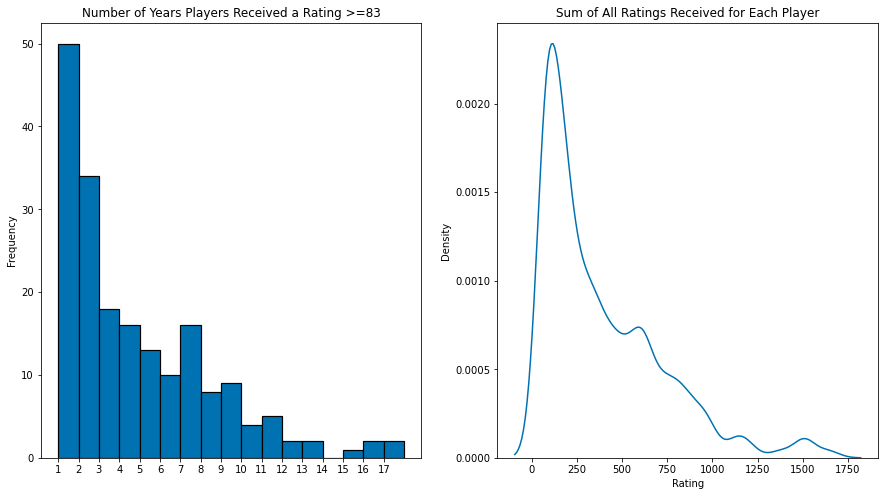

In [24]:
print("Mean Number of Years a Player had a Rating >=83 (2001-2021): " + str(round(df.Name.value_counts().mean(),2)))
print("Stadard Deviation: " + str(round(df.Name.value_counts().std(),2)) + "\n")

print("Mean Sum of all Ratings Received by Each Player (2001-2021): " + str(round(df.groupby('Name')['Rating'].sum().mean(),2)))
print("Stadard Deviation: " + str(round(df.groupby('Name')['Rating'].sum().std(),2)))

fig, axs = plt.subplots(ncols=2, figsize=(15, 8))

df.Name.value_counts().plot(kind = "hist", bins = range(1,19), xticks = range(1,18), 
                            title = "Number of Years Players Received a Rating >=83", 
                            xlabel = "Years", edgecolor='black', linewidth=1.2, ax = axs[0])

sns.kdeplot(df.groupby('Name')['Rating'].sum(), bw_adjust = 0.5, ax = axs[1]).set_title("Sum of All Ratings Received for Each Player")


The above charts suggest that a great number of NBA players only have one or two standout seasons during their career. However this data may be skewed by younger players in recent years. For example, Zion Williamson received his first rating of >=83 in the 2021 season. It is expected he will be a perennial all-star and thus receive many more high ratings over the course of his career. In order to remove this misleading data we look at the same two charts, but with data from 2020 and 2021 removed. In this way, players who only received a high rating in a single year will be less likely to be rising stars who only recently entered the NBA.

Mean Number of Years a Player had a Rating >=83 (2001-2021): 4.54
Stadard Deviation: 3.61

Mean Sum of all Ratings Received by Each Player (2001-2021): 402.23
Stadard Deviation: 331.14


Text(0.5, 1.0, 'Sum of All Ratings Received for Each Player')

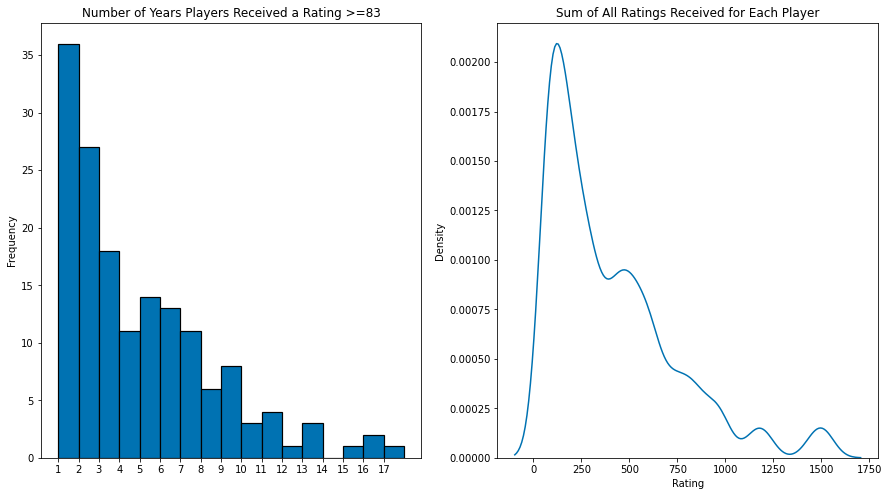

In [25]:
countsFrame = df.loc[(df['Year'] != 2020) & (df['Year'] != 2021)]
counts = countsFrame.Name.value_counts()
print("Mean Number of Years a Player had a Rating >=83 (2001-2021): " + str(round(counts.mean(),2)))
print("Stadard Deviation: " + str(round(counts.std(),2)) + "\n")

print("Mean Sum of all Ratings Received by Each Player (2001-2021): " + str(round(countsFrame.groupby('Name')['Rating'].sum().mean(),2)))
print("Stadard Deviation: " + str(round(countsFrame.groupby('Name')['Rating'].sum().std(),2)))

fig, axs = plt.subplots(ncols=2, figsize=(15, 8))

counts.plot(kind = "hist", bins = range(1,19), xticks = range(1,18), 
                            title = "Number of Years Players Received a Rating >=83", 
                            xlabel = "Years", edgecolor='black', linewidth=1.2, ax = axs[0])

sns.kdeplot(countsFrame.groupby('Name')['Rating'].sum(), bw_adjust = 0.5, ax = axs[1]).set_title("Sum of All Ratings Received for Each Player")

The above charts show that even when removing the data from 2020 and 2021 many players only receive high ratings for one or two years during their career. We also note that the histogram frequencies do not drop as dramatically after 3 years. This suggests that once a player manages to play at a high level for three years, the data suggests they are likely to be a perennial all-star who continues to play at a high level.

We will now close our analysis with a few interesting details. Below is a list of 99 rated players, the highest rating possible. We note that according to the NBA 2k ratings the best possible team which can be formed from payers over the last 21 years is as follows  

**PG: Chris Paul, 2009**
**SG: Kobe Bryant, 2005; Kobe Bryant, 2009**
**SF: LeBron James, 2009; LeBron James, 2014**
**PF: Kevin Garnett, 2001; Tim Duncan, 2004; Kevin Garnett, 2005; Kevin Garnett, 2006; Tim Duncan, 2006; Kevin Garnett, 2009**
**C: Shaquille O'Neal, 2002**

In [26]:
print("99 Rated Players:\n")
print(df[df['Rating'].values == df['Rating'].values.max()].to_string(index = False))

99 Rated Players:

Position             Name  Rating         Team  Year
      PF    Kevin Garnett      99 Timberwolves  2001
       C Shaquille O'Neal      99       Lakers  2002
      PF       Tim Duncan      99        Spurs  2004
      SG      Kobe Bryant      99       Lakers  2005
      PF    Kevin Garnett      99 Timberwolves  2005
      PF    Kevin Garnett      99 Timberwolves  2006
      PF       Tim Duncan      99        Spurs  2006
      SF     LeBron James      99    Cavaliers  2009
      SG      Kobe Bryant      99       Lakers  2009
      PF    Kevin Garnett      99      Celtics  2009
      PG       Chris Paul      99      Hornets  2009
      SF     LeBron James      99         Heat  2014


Looking at longevity we see that only 5 players have received a rating >= 83 for 15 years or more. Two of these players (LeBron James and Chris Paul) are still active.

In [27]:
print("Number of Years with a Rating >= 83: \n" + df.Name.value_counts().head().to_string() + "\n")

Number of Years with a Rating >= 83: 
LeBron James     17
Dirk Nowitzki    17
Kobe Bryant      16
Tim Duncan       16
Chris Paul       15



If we sum the ratings every player received over their career, we find that nine players have a total of more than 1000. Of these three players (LeBron James, Chris Paul, and Carmelo Anthony) are still active. Paul Pierce has a rating sum of 998, so he missed inclusion in the 1000-point club by a mere two points.

In [28]:
print("Player Rating Sum: \n" + df.groupby('Name')['Rating'].sum().sort_values(ascending = False).head(9).to_string() + "\n")

Player Rating Sum: 
Name
LeBron James       1644
Kobe Bryant        1525
Dirk Nowitzki      1509
Tim Duncan         1491
Chris Paul         1374
Dwyane Wade        1207
Carmelo Anthony    1167
Kevin Garnett      1134
Kevin Durant       1117



Future directions for this project could include a linear regression with a team's rating sum as the explanatory variable and the team's winning percentage as the response variable. Tracking specific players over the course of their career could also yield interesting results. Perhaps most useful would be creating a data set which included all players, not just those with a rating >=83, and performing similar analysis.

Position Count: 
PG    208
PF    187
SG    179
SF    156
C     114

Player Count: 
LeBron James             17
Dirk Nowitzki            17
Kobe Bryant              16
Tim Duncan               16
Chris Paul               15
Carmelo Anthony          13
Dwyane Wade              13
Kevin Garnett            12
Kevin Durant             12
Manu Ginobili            11
Paul Pierce              11
Steve Nash               11
Dwight Howard            11
LaMarcus Aldridge        11
Blake Griffin            10
Pau Gasol                10
Jason Kidd               10
Russell Westbrook        10
Allen Iverson             9
Chris Bosh                9
Tony Parker               9
Kyrie Irving              9
Ray Allen                 9
John Wall                 9
Vince Carter              9
Tracy McGrady             9
Shaquille O'Neal          9
Kyle Lowry                8
Joe Johnson               8
Stephen Curry             8
Shawn Marion              8
James Harden              8
Elton Brand          

<AxesSubplot:title={'center':"LeBron James' Rating"}, xlabel='Year', ylabel='Rating'>

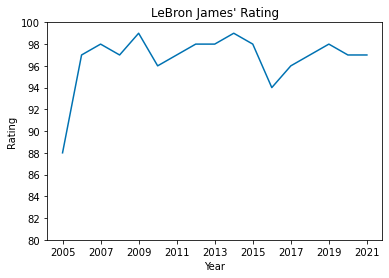

In [29]:
countsFrame = df.loc[(df['Year'] != 2020) & (df['Year'] != 2021)]
print("Position Count: \n" + df.Position.value_counts().to_string() + "\n")

print("Player Count: \n" + df.Name.value_counts().to_string() + "\n")

print("Rating Count: \n" + df.Rating.value_counts(sort = False).to_string() + "\n")

print("Year Count: \n" + df.Year.value_counts(sort = False).to_string() + "\n")

print("Team Count: \n" + df.Team.value_counts().to_string() + "\n")

print("Player Rating Sum: \n" + df.groupby('Name')['Rating'].sum().sort_values(ascending = False).to_string() + "\n")

print("Position Rating Sum:\n" + df.groupby('Position')['Rating'].sum().sort_values(ascending = False).to_string() + "\n")

print("Team Rating Sum:\n" + df.groupby('Team')['Rating'].sum().sort_values(ascending = False).to_string() + "\n")

print("\n 99 Rated Players:")

print(df[df['Rating'].values == df['Rating'].values.max()])

print("\n Top Rated Players by Position:")

print(df.loc[df.groupby('Position')['Rating'].idxmax()])

print(df.loc[df['Name'] == 'LeBron James'])

df1 = df.loc[df['Name'] == 'LeBron James']
cols = [4,2]
df1 = df1.iloc[:,cols]
df1.set_index("Year", inplace = True)
df1.plot(title = "LeBron James' Rating", legend = False, ylabel = "Rating", xticks = list(range(2005,2022,2)),yticks = list(range(80,101,2)))